# Vessel Detection Cross-Validation Evaluation

This notebook provides a comprehensive visualization and analysis of vessel detection results
across 4 datasets with 5-fold cross-validation. The analysis includes:

1. Performance metrics summary
2. ROC curves and Precision-Recall curves
3. Confusion matrices
4. Cross-dataset performance comparison
5. Per-fold analysis and variance assessment
6. Statistical significance testing
7. Threshold optimization analysis

In [15]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings("ignore")

# Set plot styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
colors = sns.color_palette("tab10")

# Configure plot defaults
FIGSIZE = (12, 8)
plt.rcParams['figure.figsize'] = FIGSIZE
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# Define dataset names - update these to match your actual datasets
DATASETS = ["Original_1", "Augmented_2", "Mixed_3", "Synthetic_4"]
N_FOLDS = 5  # 5-fold cross-validation

In [16]:
def load_all_results(base_path=r"E:\Datasets\masati-thesis\results"):
    """
    Load all results.csv files for each dataset and fold.
    Expected structure: <base_path>/<dataset>/results/fold_X/results.csv

    Returns a nested dictionary: results[dataset][fold] = dataframe
    """
    results = {}

    print("Searching for result files...")

    for dataset in DATASETS:
        results[dataset] = {}
        dataset_path = os.path.join(base_path, dataset, 'results')

        print(f"Dataset: {dataset}")

        # Search pattern for: fold_X/results.csv
        csv_paths = glob.glob(os.path.join(dataset_path, "fold_*", "results.csv"))
        print(dataset_path)

        if csv_paths:
            for csv_path in csv_paths:
                # Extract fold number from folder name (fold_0)
                fold_folder = os.path.basename(os.path.dirname(csv_path))
                fold = int(fold_folder.replace("fold_", ""))
                print(f"  - Loading fold {fold} from {csv_path}")
                results[dataset][fold] = pd.read_csv(csv_path)

        else:
            # If no files found, simulate data
            print(f"  - No result files found for {dataset}. Using simulated data.")
            for fold in range(N_FOLDS):
                np.random.seed(1583891 + ord(dataset[0]) + fold)
                n_samples = 1000

                base_threshold = 0.5 + (ord(dataset[-1]) % 4) * 0.05
                base_accuracy = 0.75 + (ord(dataset[-1]) % 4) * 0.05

                df = pd.DataFrame({
                    'true_label': np.random.randint(0, 2, n_samples),
                    'confidence': np.random.beta(5, 2, n_samples) * 0.8 + 0.1,
                    'threshold': [base_threshold] * n_samples,
                    'fold': [fold] * n_samples,
                    'dataset': [dataset] * n_samples
                })

                df['predicted_label'] = (df['confidence'] > df['threshold']).astype(int)

                correction_mask = np.random.choice(
                    [True, False],
                    size=n_samples,
                    p=[base_accuracy + (fold * 0.01), 1 - (base_accuracy + (fold * 0.01))]
                )
                df.loc[correction_mask, 'predicted_label'] = df.loc[correction_mask, 'true_label']

                results[dataset][fold] = df

    print("\nData loading complete.")
    return results

# Load the results (or create simulated data if no files found)
results = load_all_results()

Searching for result files...
Dataset: Original_1
E:\Datasets\masati-thesis\results\Original_1\results
  - Loading fold 0 from E:\Datasets\masati-thesis\results\Original_1\results\fold_0\results.csv
  - Loading fold 1 from E:\Datasets\masati-thesis\results\Original_1\results\fold_1\results.csv
  - Loading fold 2 from E:\Datasets\masati-thesis\results\Original_1\results\fold_2\results.csv
  - Loading fold 3 from E:\Datasets\masati-thesis\results\Original_1\results\fold_3\results.csv
  - Loading fold 4 from E:\Datasets\masati-thesis\results\Original_1\results\fold_4\results.csv
Dataset: Augmented_2
E:\Datasets\masati-thesis\results\Augmented_2\results
  - Loading fold 0 from E:\Datasets\masati-thesis\results\Augmented_2\results\fold_0\results.csv
  - Loading fold 1 from E:\Datasets\masati-thesis\results\Augmented_2\results\fold_1\results.csv
  - Loading fold 2 from E:\Datasets\masati-thesis\results\Augmented_2\results\fold_2\results.csv
  - Loading fold 3 from E:\Datasets\masati-thesis\r

In [17]:
# Helper functions for metrics calculation
def calculate_training_metrics(df):
    """
    Calculate summarized training/validation metrics from a YOLOv8 training log CSV.
    Uses the last epoch's values by default.
    """
    last_epoch = df.iloc[-1]

    metrics = {
        'Precision': last_epoch['metrics/precision(B)'],
        'Recall': last_epoch['metrics/recall(B)'],
        'mAP50': last_epoch['metrics/mAP50(B)'],
        'mAP50-95': last_epoch['metrics/mAP50-95(B)'],
        'Train Box Loss': last_epoch['train/box_loss'],
        'Train Cls Loss': last_epoch['train/cls_loss'],
        'Train DFL Loss': last_epoch['train/dfl_loss'],
        'Val Box Loss': last_epoch['val/box_loss'],
        'Val Cls Loss': last_epoch['val/cls_loss'],
        'Val DFL Loss': last_epoch['val/dfl_loss'],
    }

    return metrics


def metrics_for_all_datasets(results):
    """
    Calculate summarized training metrics (like mAP, precision) for all datasets and folds.
    Assumes each DataFrame is a YOLO training log.
    """
    all_metrics = []

    for dataset in results:
        for fold in results[dataset]:
            df = results[dataset][fold]
            metrics = calculate_training_metrics(df)
            metrics['Dataset'] = dataset
            metrics['Fold'] = fold
            all_metrics.append(metrics)

    return pd.DataFrame(all_metrics)

## Performance Metrics Summary

In [18]:
# Display summary of metrics aggregated by dataset
metrics_df = metrics_for_all_datasets(results)
metrics_summary = metrics_df.groupby('Dataset').mean().drop(['TP', 'TN', 'FP', 'FN', 'Fold'], axis=1, errors='ignore')
metrics_summary

,Precision,Recall,mAP50,mAP50-95,Train Box Loss,Train Cls Loss,Train DFL Loss,Val Box Loss,Val Cls Loss,Val DFL Loss
Dataset,,,,,,,,,,
Augmented_2,0.699894,0.625494,0.646122,0.243382,2.095086,1.171598,1.058052,2.025610,1.280194,0.970096
Mixed_3,0.698562,0.632414,0.645730,0.246258,2.072166,1.155124,1.049064,1.891420,1.258872,0.916632
Original_1,0.782706,0.622882,0.716860,0.310480,1.770200,1.057362,0.955086,0.977706,1.102584,0.513476
Synthetic_4,0.729680,0.625340,0.661072,0.252464,2.088888,1.177876,1.056702,1.914682,1.241308,0.929138


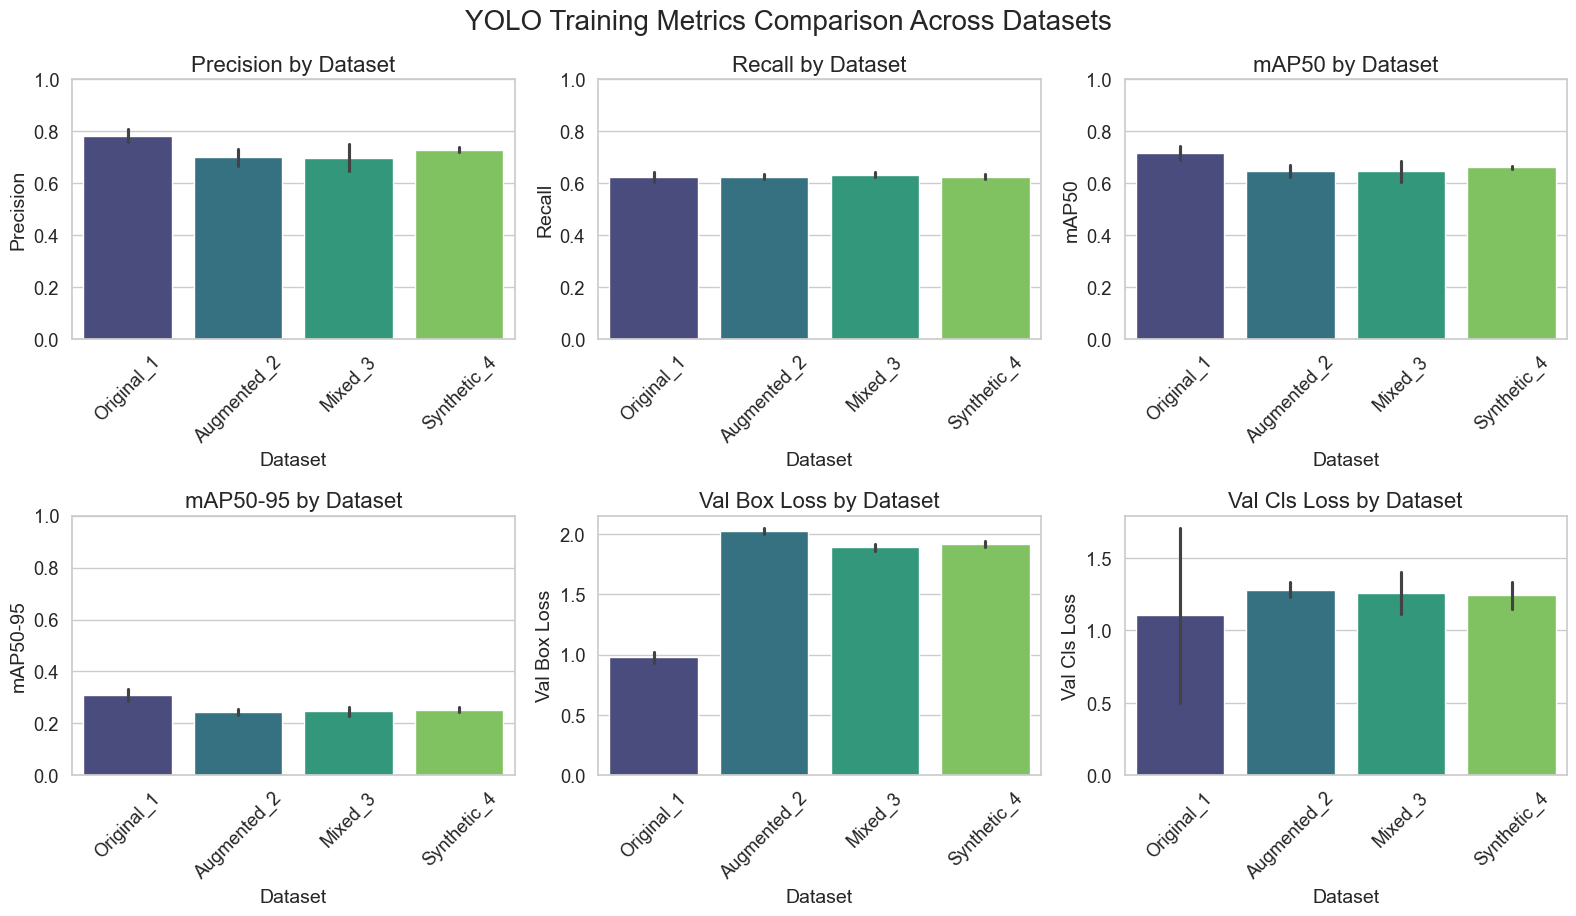

In [29]:
# Choose metrics to visualize
metrics_to_plot = ['Precision', 'Recall', 'mAP50', 'mAP50-95', 'Val Box Loss', 'Val Cls Loss']

# Convert 'Dataset' column to categorical for correct ordering
metrics_df['Dataset'] = pd.Categorical(metrics_df['Dataset'], categories=DATASETS, ordered=True)

# Create plot
plt.figure(figsize=(16, 12))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(3, 3, i + 1)
    sns.barplot(x='Dataset', y=metric, data=metrics_df, palette='viridis', ci='sd')
    plt.title(f'{metric} by Dataset')
    if 'Loss' not in metric:
        plt.ylim(0.0, 1.0)  # For normalized metrics like precision/recall
    plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle('YOLO Training Metrics Comparison Across Datasets', fontsize=20, y=1.02)
plt.show()

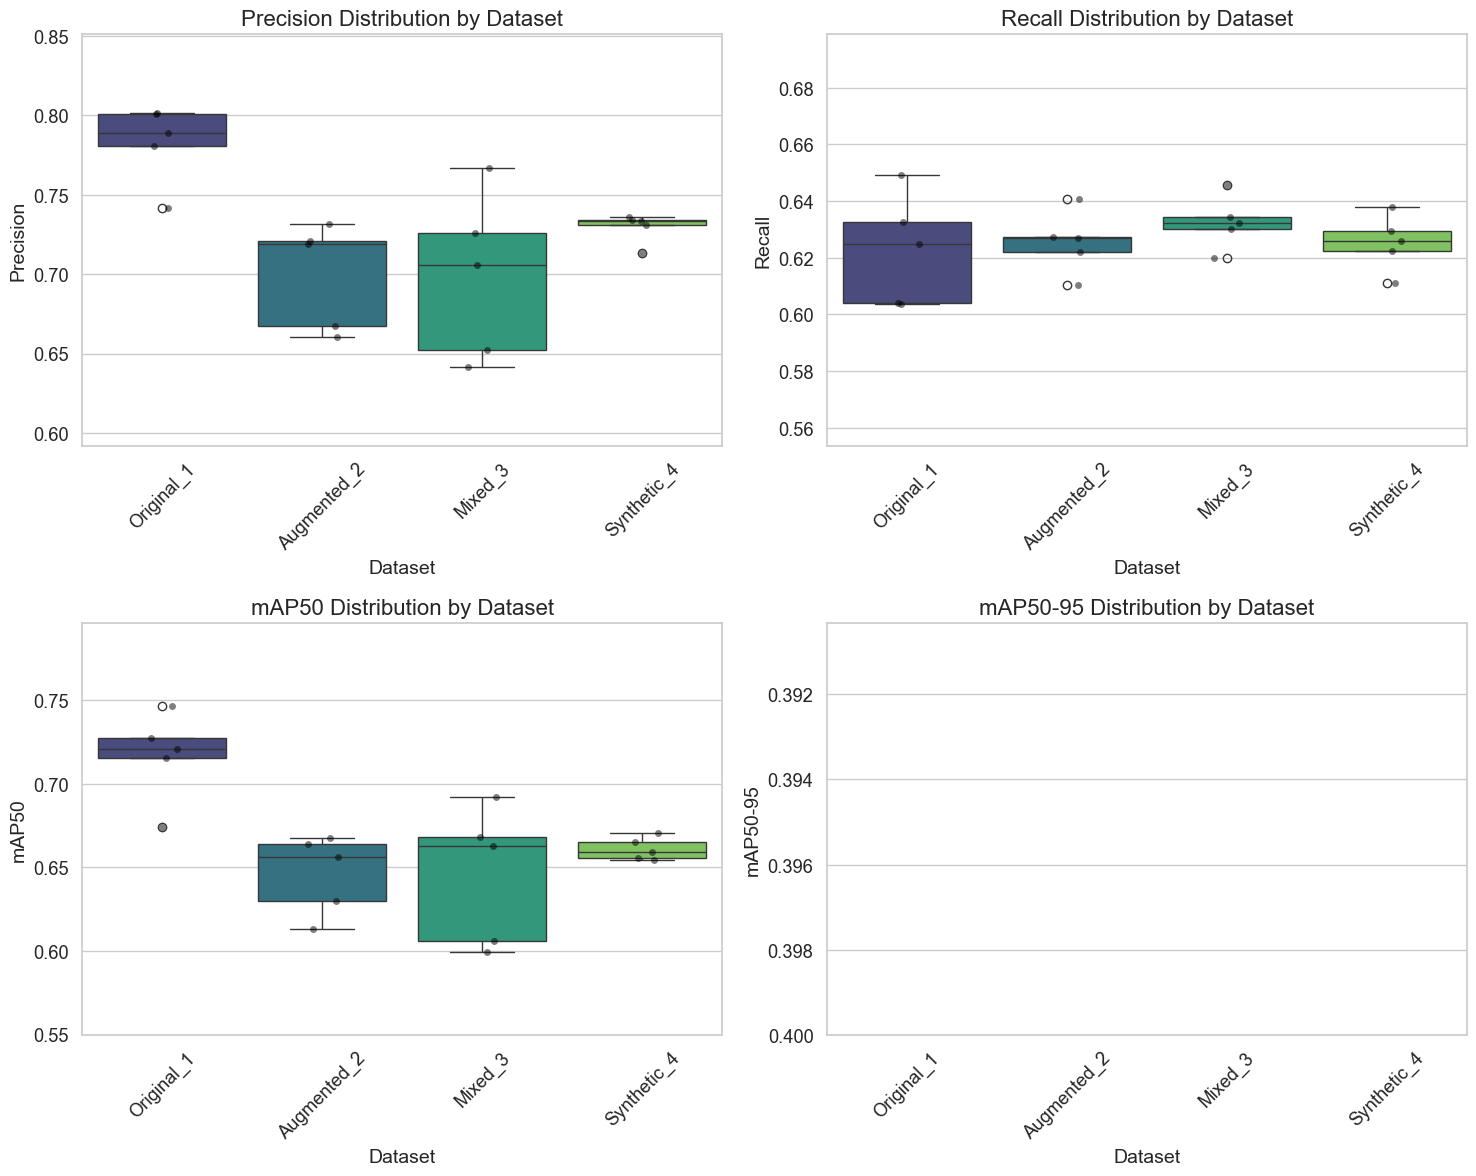

In [20]:
# Visualize fold variation within each dataset
plt.figure(figsize=(15, 12))

for i, metric in enumerate(metrics_to_plot[:4]):  # Plot first 4 metrics only
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Dataset', y=metric, data=metrics_df, palette='viridis')
    sns.stripplot(x='Dataset', y=metric, data=metrics_df, color='black', size=5, alpha=0.5)
    plt.title(f'{metric} Distribution by Dataset')
    plt.ylim(max(0.4, metrics_df[metric].min() - 0.05), min(1.0, metrics_df[metric].max() + 0.05))
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

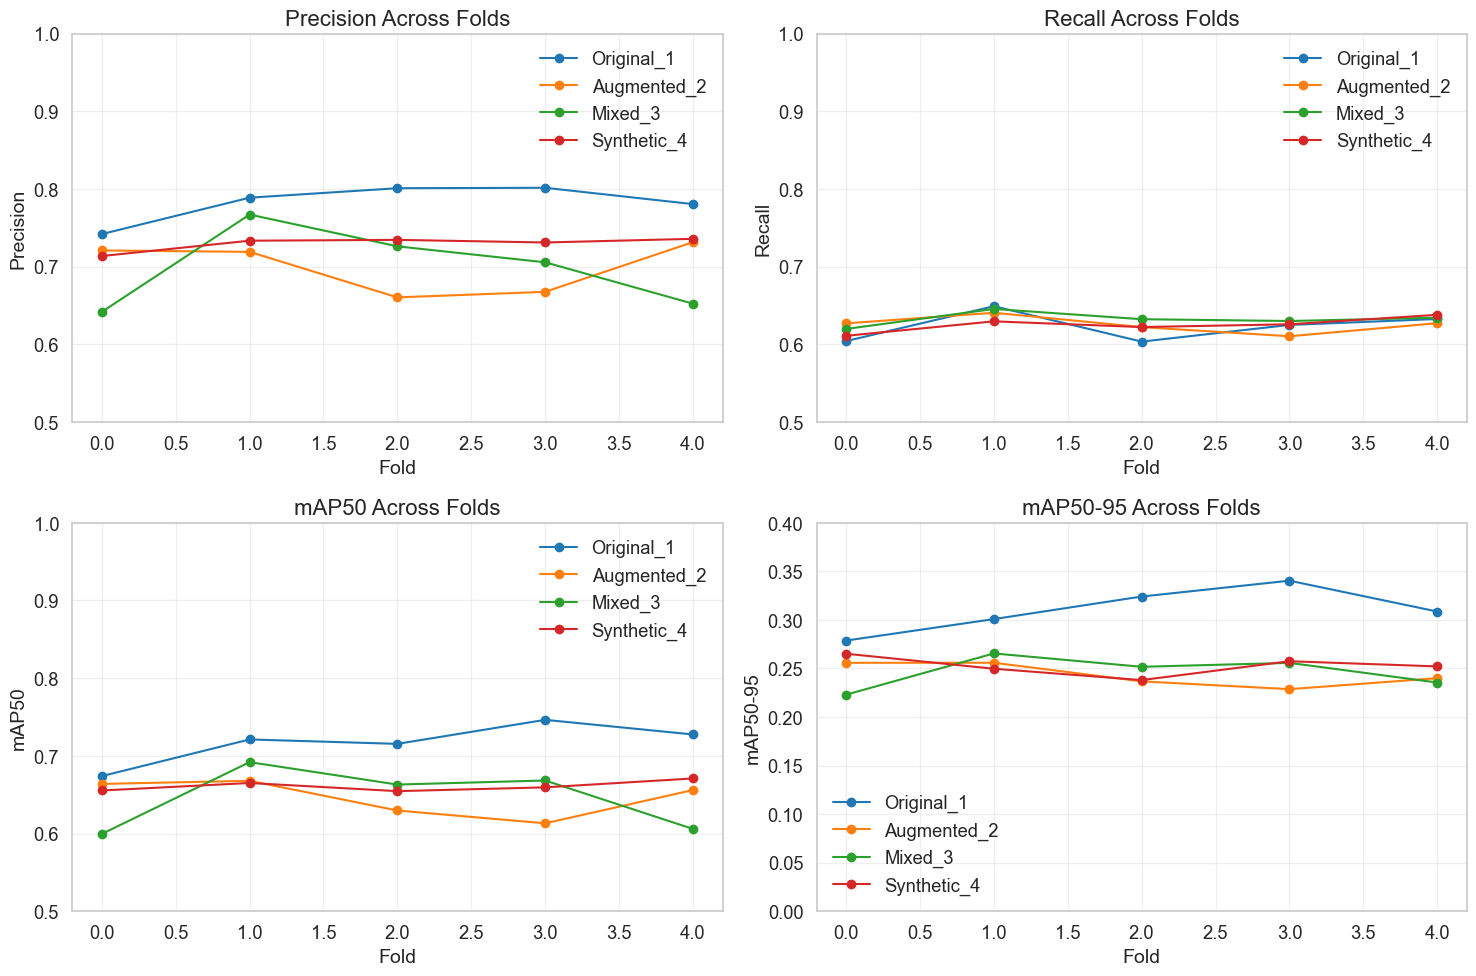

In [41]:
# Example color palette
colors = sns.color_palette('tab10', n_colors=len(DATASETS))

# Ensure 'Dataset' is treated as a categorical variable with the specified order
metrics_df['Dataset'] = pd.Categorical(metrics_df['Dataset'], categories=DATASETS, ordered=True)

# Plot fold-wise performance trends
plt.figure(figsize=(15, 10))

for i, metric in enumerate(['Precision', 'Recall', 'mAP50', 'mAP50-95']):
    plt.subplot(2, 2, i + 1)
    for j, dataset in enumerate(DATASETS):
        dataset_metrics = metrics_df[metrics_df['Dataset'] == dataset]
        plt.plot(dataset_metrics['Fold'], dataset_metrics[metric], 'o-', label=dataset, color=colors[j])

    plt.title(f'{metric} Across Folds')
    plt.xlabel('Fold')
    plt.ylabel(metric)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Set specific ylim for 'mAP50-95' to ensure data visibility
    if metric == 'mAP50-95':
        plt.ylim(0.0, 0.4)  # Adjusted range for mAP50-95
    else:
        plt.ylim(0.5, 1.0)  # Default range for other metrics

plt.tight_layout()
#plt.suptitle('Fold-wise YOLO Performance Trends by Dataset', fontsize=18, fontweight="bold", y=1.02)
plt.show()

## Statistical Analysis of Performance Variance

In [22]:
# Calculate mean, std, and CV for YOLO metrics
stat_analysis = metrics_df.groupby('Dataset').agg({
    'Precision': ['mean', 'std', lambda x: x.std() / x.mean()],
    'Recall': ['mean', 'std', lambda x: x.std() / x.mean()],
    'mAP50': ['mean', 'std', lambda x: x.std() / x.mean()],
    'mAP50-95': ['mean', 'std', lambda x: x.std() / x.mean()]
})

# Rename columns: replace <lambda_0> with 'cv'
stat_analysis.columns = [
    f'{metric}_{stat}' if stat != '<lambda_0>' else f'{metric}_cv'
    for metric, stat in stat_analysis.columns
]

# Optional: reset index for easier use
stat_analysis = stat_analysis.reset_index()

# Display
stat_analysis


,Dataset,Precision_mean,Precision_std,Precision_cv,Recall_mean,Recall_std,Recall_cv,mAP50_mean,mAP50_std,mAP50_cv,mAP50-95_mean,mAP50-95_std,mAP50-95_cv
0,Augmented_2,0.699894,0.033194,0.047427,0.625494,0.010867,0.017373,0.646122,0.023673,0.036639,0.243382,0.012069,0.049590
1,Mixed_3,0.698562,0.052103,0.074587,0.632414,0.009221,0.014581,0.645730,0.040796,0.063179,0.246258,0.016917,0.068697
2,Original_1,0.782706,0.024456,0.031246,0.622882,0.019421,0.031180,0.716860,0.026671,0.037206,0.310480,0.023362,0.075244
3,Synthetic_4,0.729680,0.009119,0.012498,0.625340,0.009929,0.015878,0.661072,0.006883,0.010412,0.252464,0.010024,0.039703


### Variation Statistics

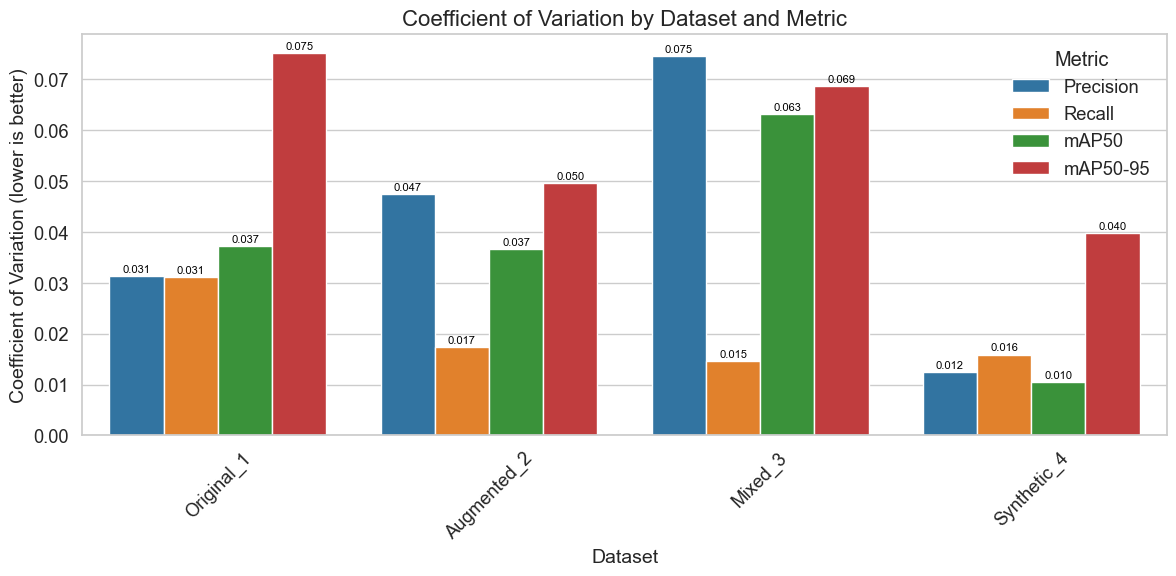

In [45]:
# Metrics that have CV stats
metrics_for_cv = ['Precision', 'Recall', 'mAP50', 'mAP50-95']
# Prepare data for plotting
cv_data = pd.DataFrame({
    'Dataset': np.repeat(DATASETS, len(metrics_for_cv)),
    'Metric': np.tile(metrics_for_cv, len(DATASETS)),
    'CV': [stat_analysis.loc[stat_analysis['Dataset'] == dataset, f'{metric}_cv'].iloc[0] for dataset in DATASETS for
           metric in metrics_for_cv]
})

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Dataset', y='CV', hue='Metric', data=cv_data)

# === ✨ Add value labels to bars ===
for p in ax.patches:
    height = p.get_height()

    if height > 0.001:  # Avoid NaNs
        ax.annotate(f"{height:.3f}",
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    fontsize=8, color='black',
                    xytext=(0, 5),
                    textcoords='offset points')

# Labels and styling
plt.title('Coefficient of Variation by Dataset and Metric')
plt.ylabel('Coefficient of Variation (lower is better)')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## Cross-Dataset Performance Ranking

<Figure size 1400x700 with 0 Axes>

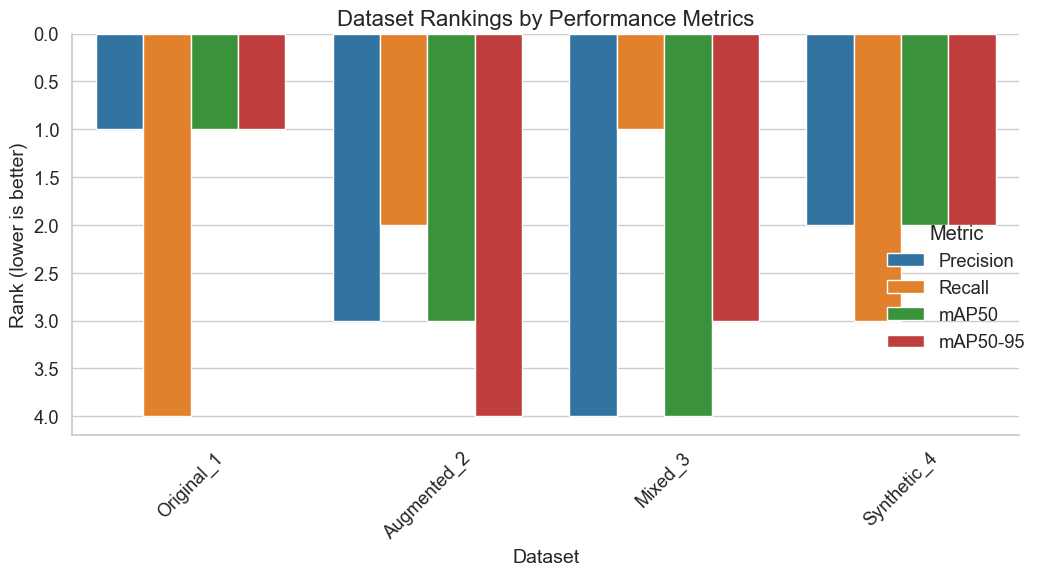

In [31]:
# Define the metrics you want to rank (adjust based on the actual column names)
rank_metrics = ['Precision', 'Recall', 'mAP50', 'mAP50-95']

# If you want to add additional metrics like AUROC, AUPRC (if they exist in your dataset)
if 'AUROC' in metrics_df.columns:
    rank_metrics.extend(['AUROC', 'AUPRC'])

# Ensure 'Dataset' is treated as a categorical variable with the specified order
metrics_df['Dataset'] = pd.Categorical(metrics_df['Dataset'], categories=DATASETS, ordered=True)

ranking_data = []

# Rank datasets by each metric
for metric in rank_metrics:
    # Get average metric per dataset (group by your dataset column, assuming you have one)
    avg_by_dataset = metrics_df.groupby('Dataset')[metric].mean().reset_index()
    # Sort and assign ranks (ascending=False for better ranks having lower values)
    avg_by_dataset['Rank'] = avg_by_dataset[metric].rank(ascending=False)
    avg_by_dataset['Metric'] = metric
    ranking_data.append(avg_by_dataset)

# Combine all metric rankings into one dataframe
ranking_df = pd.concat(ranking_data)

# Ensure 'Dataset' in ranking_df is also treated as categorical, to match the desired order in plots
ranking_df['Dataset'] = pd.Categorical(ranking_df['Dataset'], categories=DATASETS, ordered=True)

# Visualize dataset rankings
plt.figure(figsize=(14, 7))
g = sns.catplot(x='Dataset', y='Rank', hue='Metric', data=ranking_df, kind='bar', height=6, aspect=1.5, order=DATASETS)
plt.gca().invert_yaxis()  # Lower rank numbers are better
plt.title('Dataset Rankings by Performance Metrics')
plt.ylabel('Rank (lower is better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
# Overall ranking (average of all metric ranks)
overall_ranking = ranking_df.groupby('Dataset')['Rank'].mean().reset_index()
overall_ranking.columns = ['Dataset', 'Average_Rank']
overall_ranking = overall_ranking.sort_values('Average_Rank')
overall_ranking

,Dataset,Average_Rank
0,Original_1,1.75
3,Synthetic_4,2.25
1,Augmented_2,3.00
2,Mixed_3,3.00


## Performance Correlation Analysis

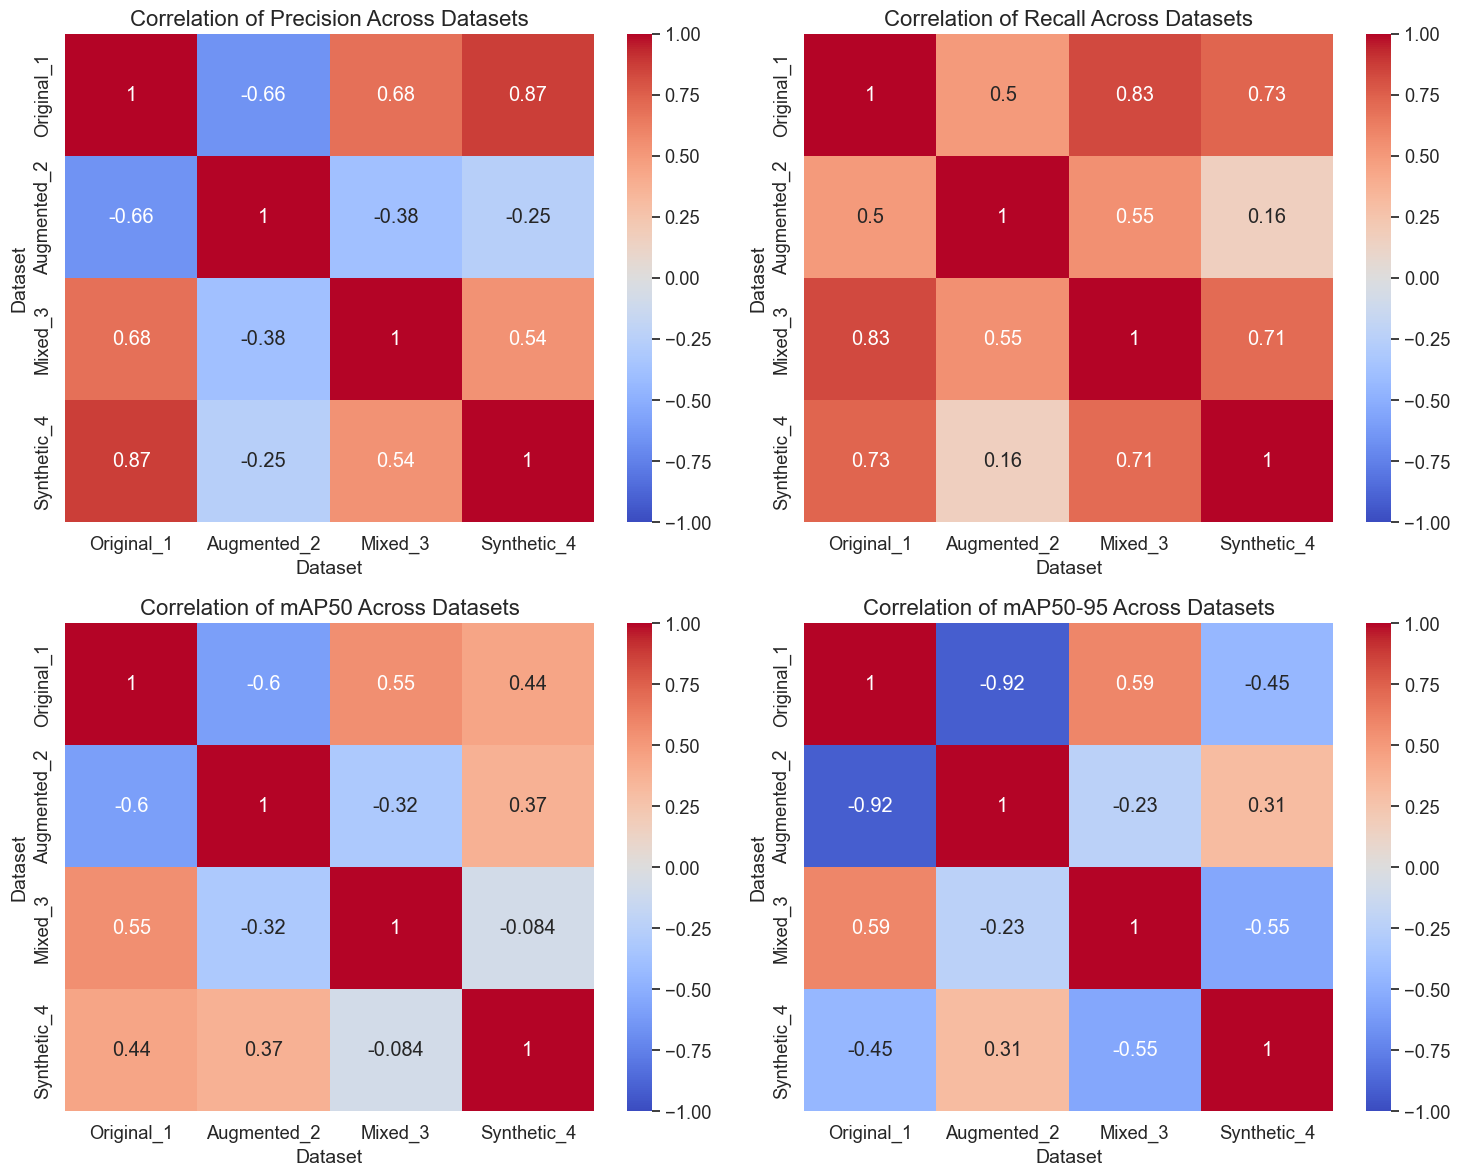

In [33]:
# List of metrics to plot
metrics = ['Precision', 'Recall', 'mAP50', 'mAP50-95']

# Create the plot with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 grid of subplots
axes = axes.flatten()  # Flatten to easily iterate over axes

# Loop over each metric to generate the heatmap
for i, metric in enumerate(metrics):
    # Create correlation matrix for the current metric
    corr_data = pd.pivot_table(
        metrics_df,
        values=metric,  # Use the current metric for correlation
        index='Fold',  # Group by fold
        columns='Dataset'
    )

    # Plot the heatmap for this metric
    sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[i])
    axes[i].set_title(f'Correlation of {metric.split("/")[-1]} Across Datasets')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

### Metric Correlation Analysis

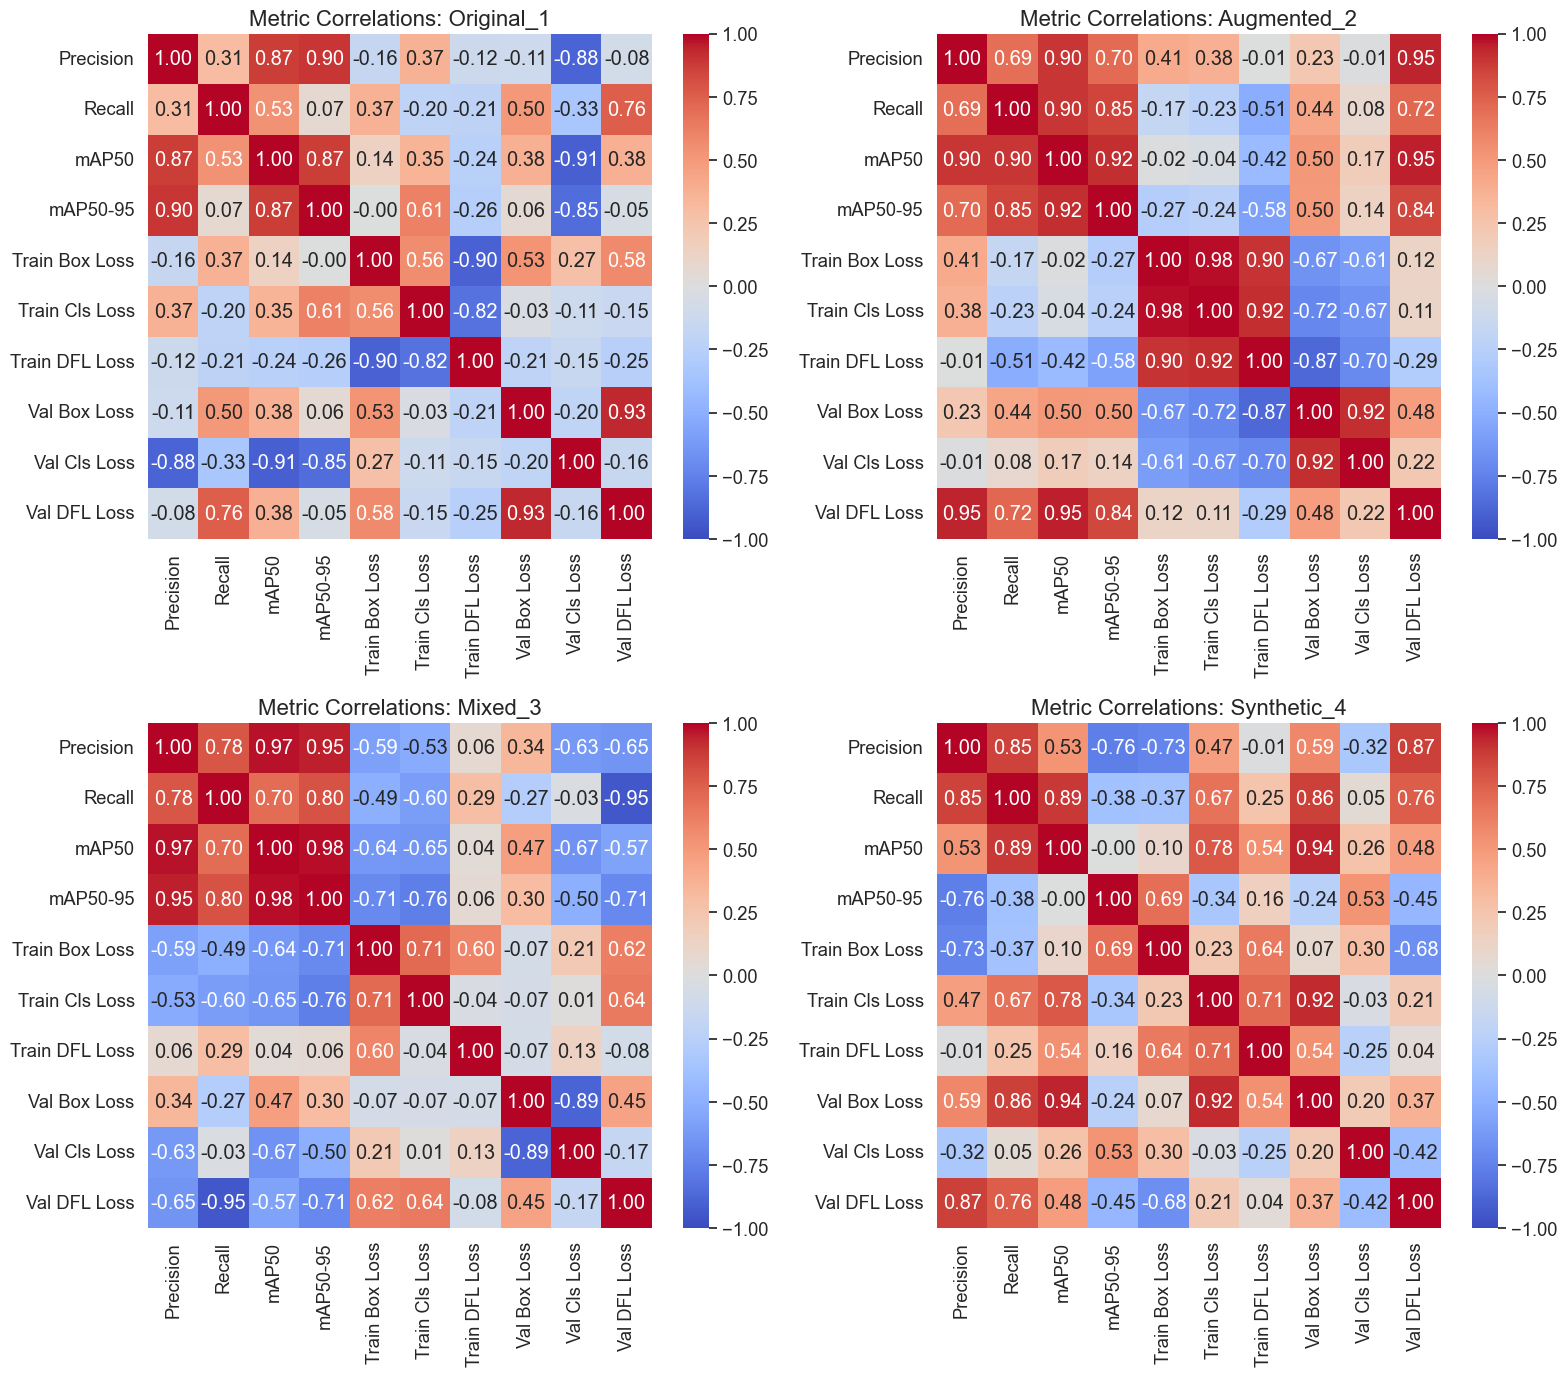

In [34]:
# Select numeric metrics for correlation
numeric_metrics = metrics_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_metrics = [m for m in numeric_metrics if m not in ['Fold', 'TP', 'TN', 'FP', 'FN']]

# Plot correlation heatmaps for each dataset
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for i, dataset in enumerate(DATASETS):
    dataset_metrics = metrics_df[metrics_df['Dataset'] == dataset][numeric_metrics]
    sns.heatmap(dataset_metrics.corr(), annot=True, cmap='coolwarm',
                vmin=-1, vmax=1, ax=axes[i], fmt='.2f')
    axes[i].set_title(f'Metric Correlations: {dataset}')

plt.tight_layout()
plt.show()